<a href="https://colab.research.google.com/github/PasinduDil/Hand-Written-Digits-Prediction/blob/main/Hand_Written_Digits_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries and data Review

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

%matplotlib inline

from scipy import stats
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve,RocCurveDisplay,roc_auc_score,auc
from sklearn.metrics import confusion_matrix,classification_report

from yellowbrick.classifier import class_prediction_error,ROCAUC

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

df0 = pd.read_csv('/content/sample_data/pendigits_txt.csv')
df=df0.copy()

##Exploratory Data Analysis

In [4]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    Min = df.min(numeric_only=True)
    Max = df.max(numeric_only=True)

    # Calculate the percentage of null values
    NullPercent = (Nulls / obs) * 100

    # Calculate the number of duplicate rows
    duplicate_count = df.duplicated().sum()

    # Create a new column to store unique values for columns with 10 or fewer unique values, otherwise '-'
    UniqueValues = df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else '-')

    # Display df.shape and duplicate count at the beginning
    print(f'1. Data shape (rows, columns): {df.shape}')
    print(f'2. Number of duplicate rows: {duplicate_count}')

    if pred is None:
        # Adjusted order with 'Uniques' at a more prominent position
        summary_df = pd.DataFrame({
            'Dtype': Types,
            'Counts': Counts,
            'Nulls': Nulls,
            'NullPercent': NullPercent,
            'Min': Min,
            'Max': Max,
            'Uniques': Uniques,
            'UniqueValues': UniqueValues
        })

    print('___________________________\nData Types:')
    print(summary_df['Dtype'].value_counts())
    print('___________________________')
    return summary_df

summary(df)

1. Data shape (rows, columns): (10992, 17)
2. Number of duplicate rows: 0
___________________________
Data Types:
Dtype
int64    17
Name: count, dtype: int64
___________________________


Dtype  Counts  Nulls  NullPercent  Min  Max  Uniques  \
input1   int64   10992      0          0.0    0  100      101   
input2   int64   10992      0          0.0    0  100       96   
input3   int64   10992      0          0.0    0  100      101   
input4   int64   10992      0          0.0    0  100       98   
input5   int64   10992      0          0.0    0  100      101   
input6   int64   10992      0          0.0    0  100      101   
input7   int64   10992      0          0.0    0  100      101   
input8   int64   10992      0          0.0    0  100      101   
input9   int64   10992      0          0.0    0  100      101   
input10  int64   10992      0          0.0    0  100      101   
input11  int64   10992      0          0.0    0  100      101   
input12  int64   10992      0          0.0    0  100      101   
input13  int64   10992      0          0.0    0  100      101   
input14  int64   10992      0          0.0    0  100      101   
input15  int64   10992      0          0.0    0  100      101   
input16  int64   10992      0          0.0    0  100      101   
class    int64   10992      0          0.0    0    9       10   

                           UniqueValues  
input1                                -  
input2                                -  
input3                                -  
input4                                -  
input5                                -  
input6                                -  
input7                                -  
input8                                -  
input9                                -  
input10                               -  
input11                               -  
input12                               -  
input13                               -  
input14                               -  
input15                               -  
input16                               -  
class    [8, 2, 1, 4, 6, 0, 5, 9, 7, 3]

In [6]:
df.describe().T

count       mean        std  min   25%   50%    75%    max
input1   10992.0  38.814320  34.257783  0.0   6.0  32.0   65.0  100.0
input2   10992.0  85.120269  16.218571  0.0  76.0  89.0  100.0  100.0
input3   10992.0  40.605622  26.342984  0.0  20.0  40.0   58.0  100.0
input4   10992.0  83.774199  19.163646  0.0  72.0  91.0  100.0  100.0
input5   10992.0  49.770378  34.100515  0.0  18.0  53.0   78.0  100.0
input6   10992.0  65.573144  26.996688  0.0  49.0  71.0   86.0  100.0
input7   10992.0  51.220251  30.576881  0.0  28.0  53.5   74.0  100.0
input8   10992.0  44.498999  29.906104  0.0  23.0  43.0   64.0  100.0
input9   10992.0  56.868541  34.135530  0.0  29.0  60.0   89.0  100.0
input10  10992.0  33.695961  27.251548  0.0   7.0  33.0   54.0  100.0
input11  10992.0  60.516376  37.288086  0.0  23.0  73.0   97.0  100.0
input12  10992.0  34.826510  27.119982  0.0  11.0  30.0   55.0  100.0
input13  10992.0  55.022289  22.335539  0.0  42.0  53.0   68.0  100.0
input14  10992.0  34.937045  33.155463  0.0   5.0  27.0   47.0  100.0
input15  10992.0  47.287482  41.760400  0.0   0.0  40.0  100.0  100.0
input16  10992.0  28.845342  35.778094  0.0   0.0   9.0   51.0  100.0
class    10992.0   4.431587   2.876947  0.0   2.0   4.0    7.0    9.0

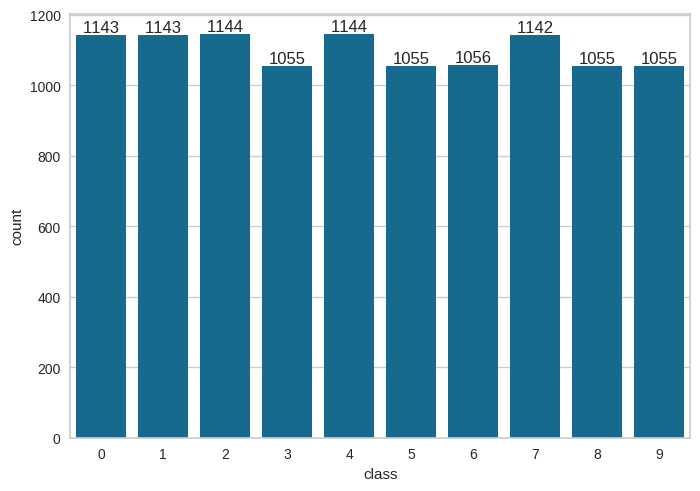

In [ ]:
ax = sns.countplot(x="class", data=df)
ax.bar_label(ax.containers[0]);

In [ ]:
import cufflinks as cf
cf.go_offline()
df.iloc[:,1:].iplot(kind="box")

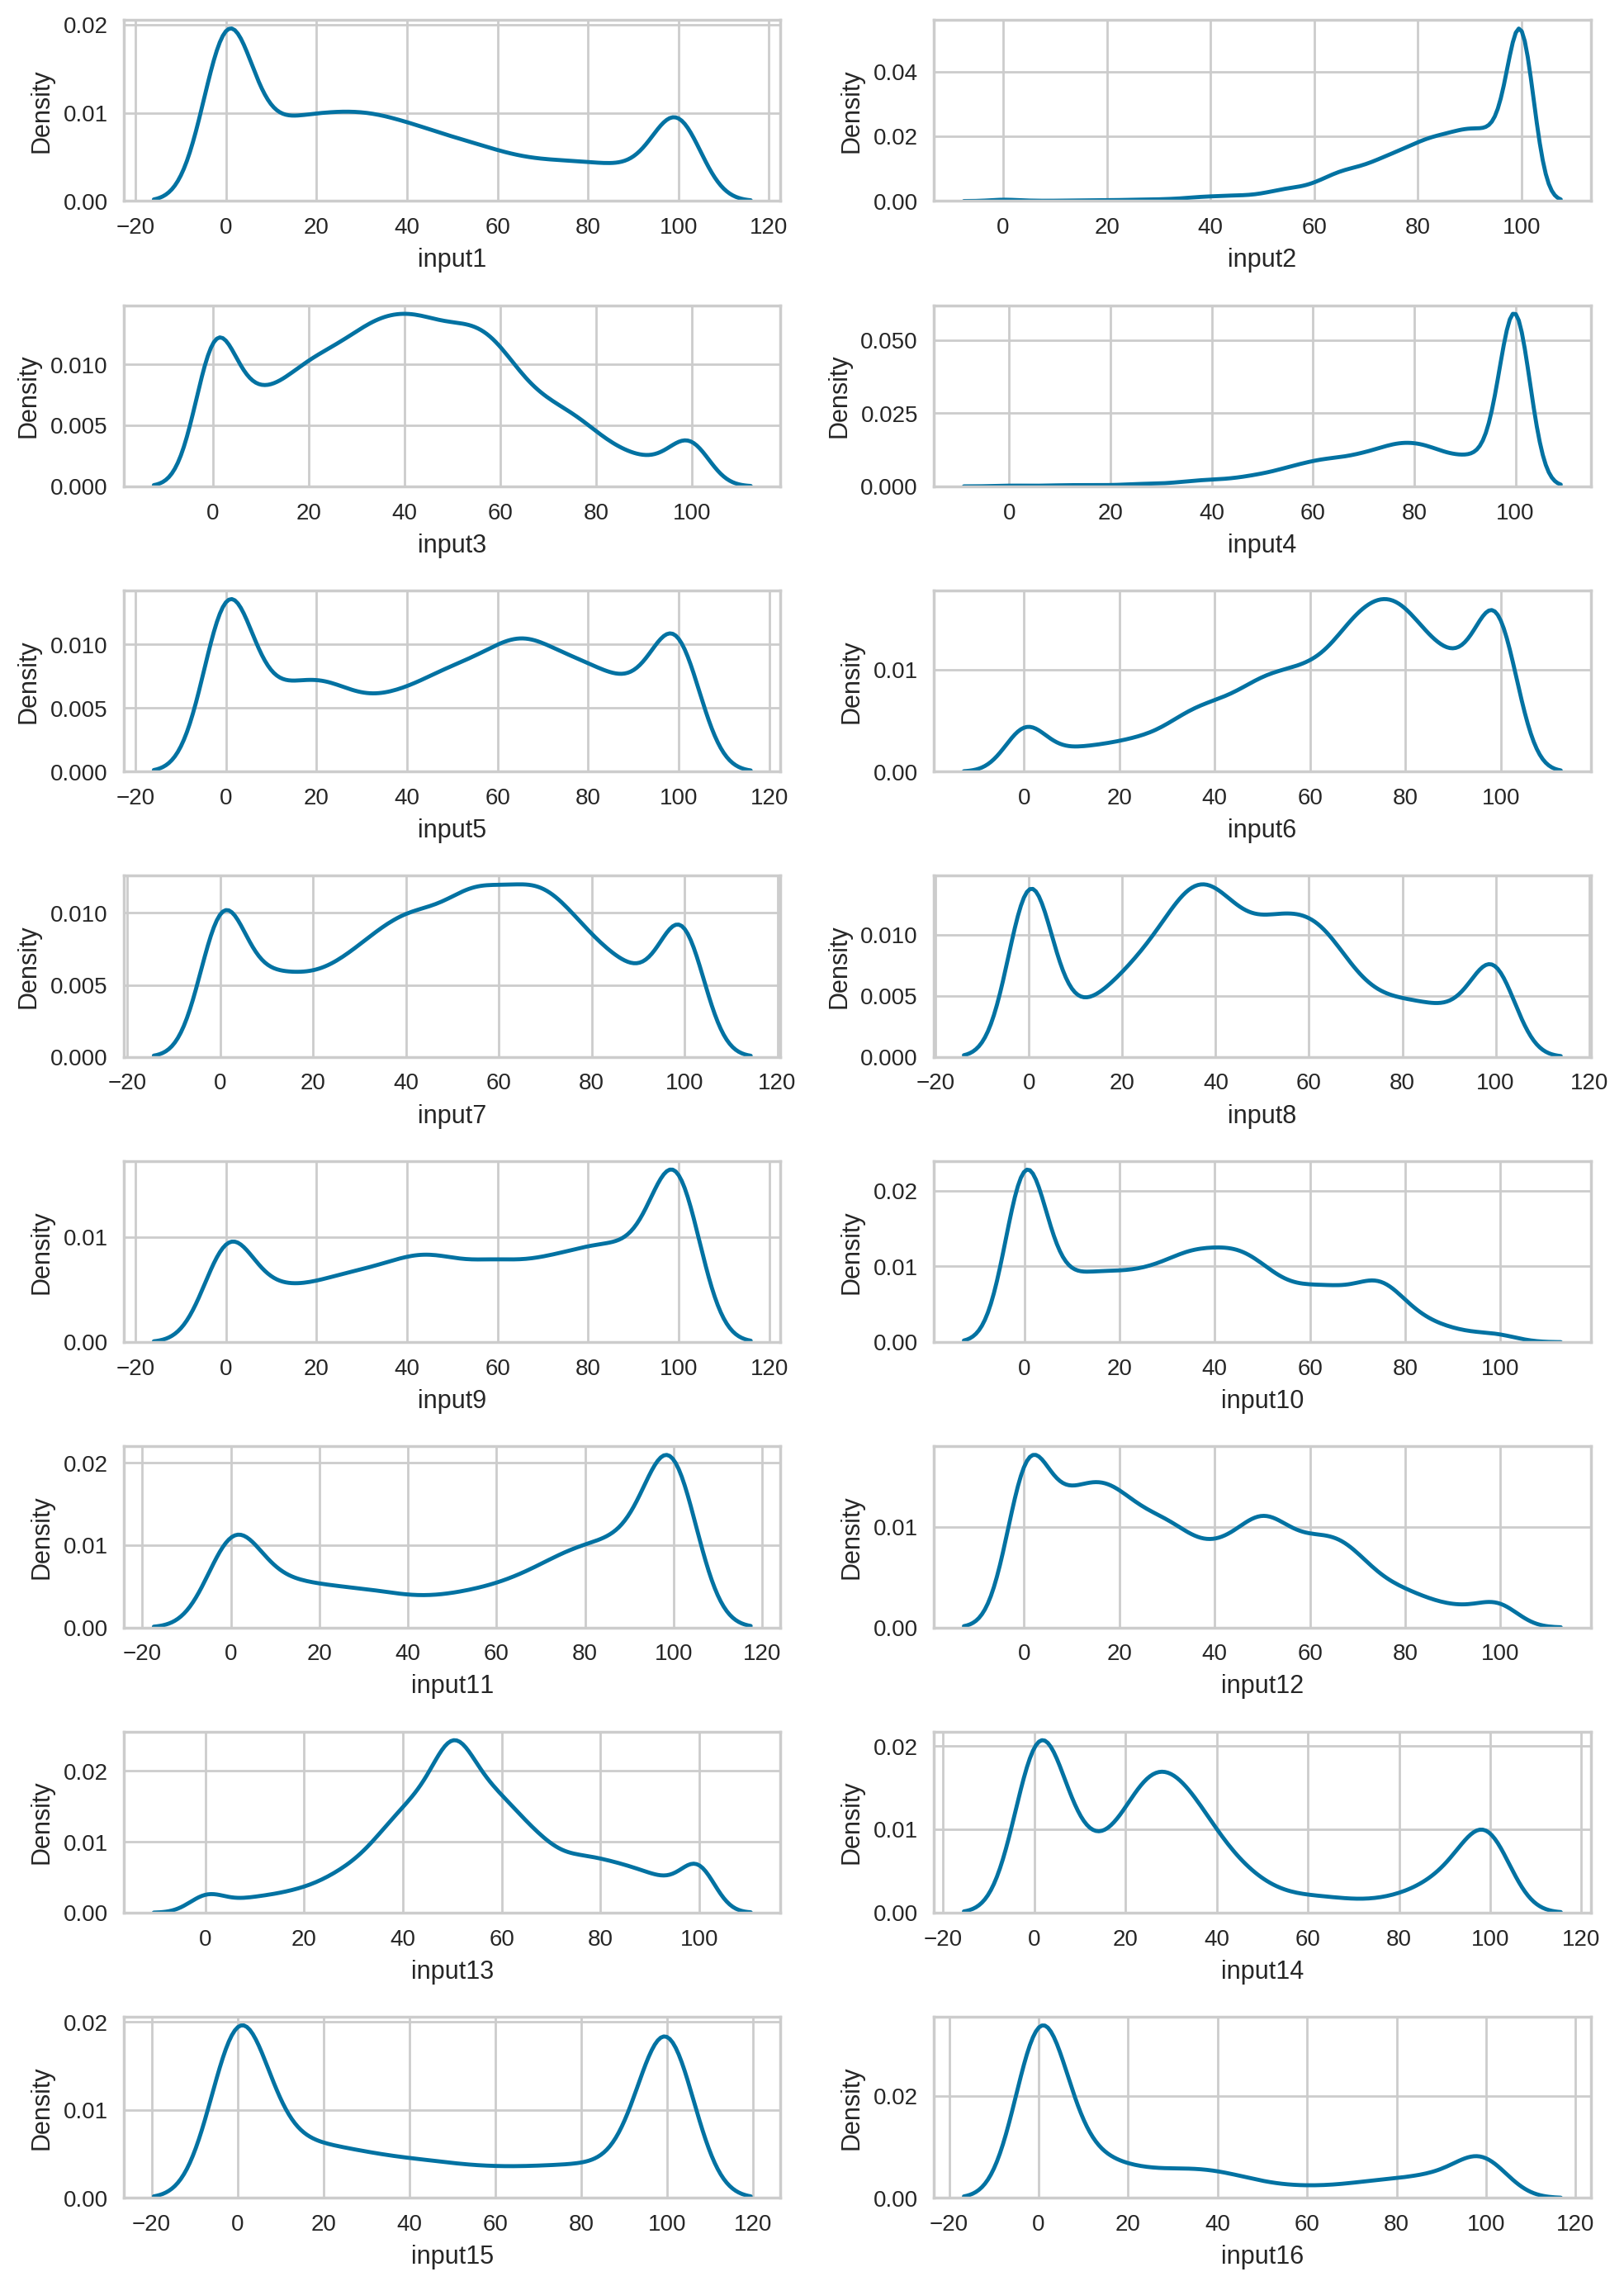

In [ ]:
fig = plt.figure(figsize=(10,14), dpi=200)
for i, col in enumerate(df.columns[:-1]):
        plt.subplot(8,2,i+1)
        sns.kdeplot(df[col])
plt.tight_layout();

In [ ]:
def plot_feature_outliers(df, hue_column):
    plt.figure(figsize=(20,30))
    for i, col in enumerate(df.columns[:-1], 1):
        plt.subplot(9, 2, i)
        plt.title(f"Distribution of {col} Data with Outliers")
        sns.boxplot(x=hue_column, y=col, data=df)
        plt.tight_layout()
    plt.show()

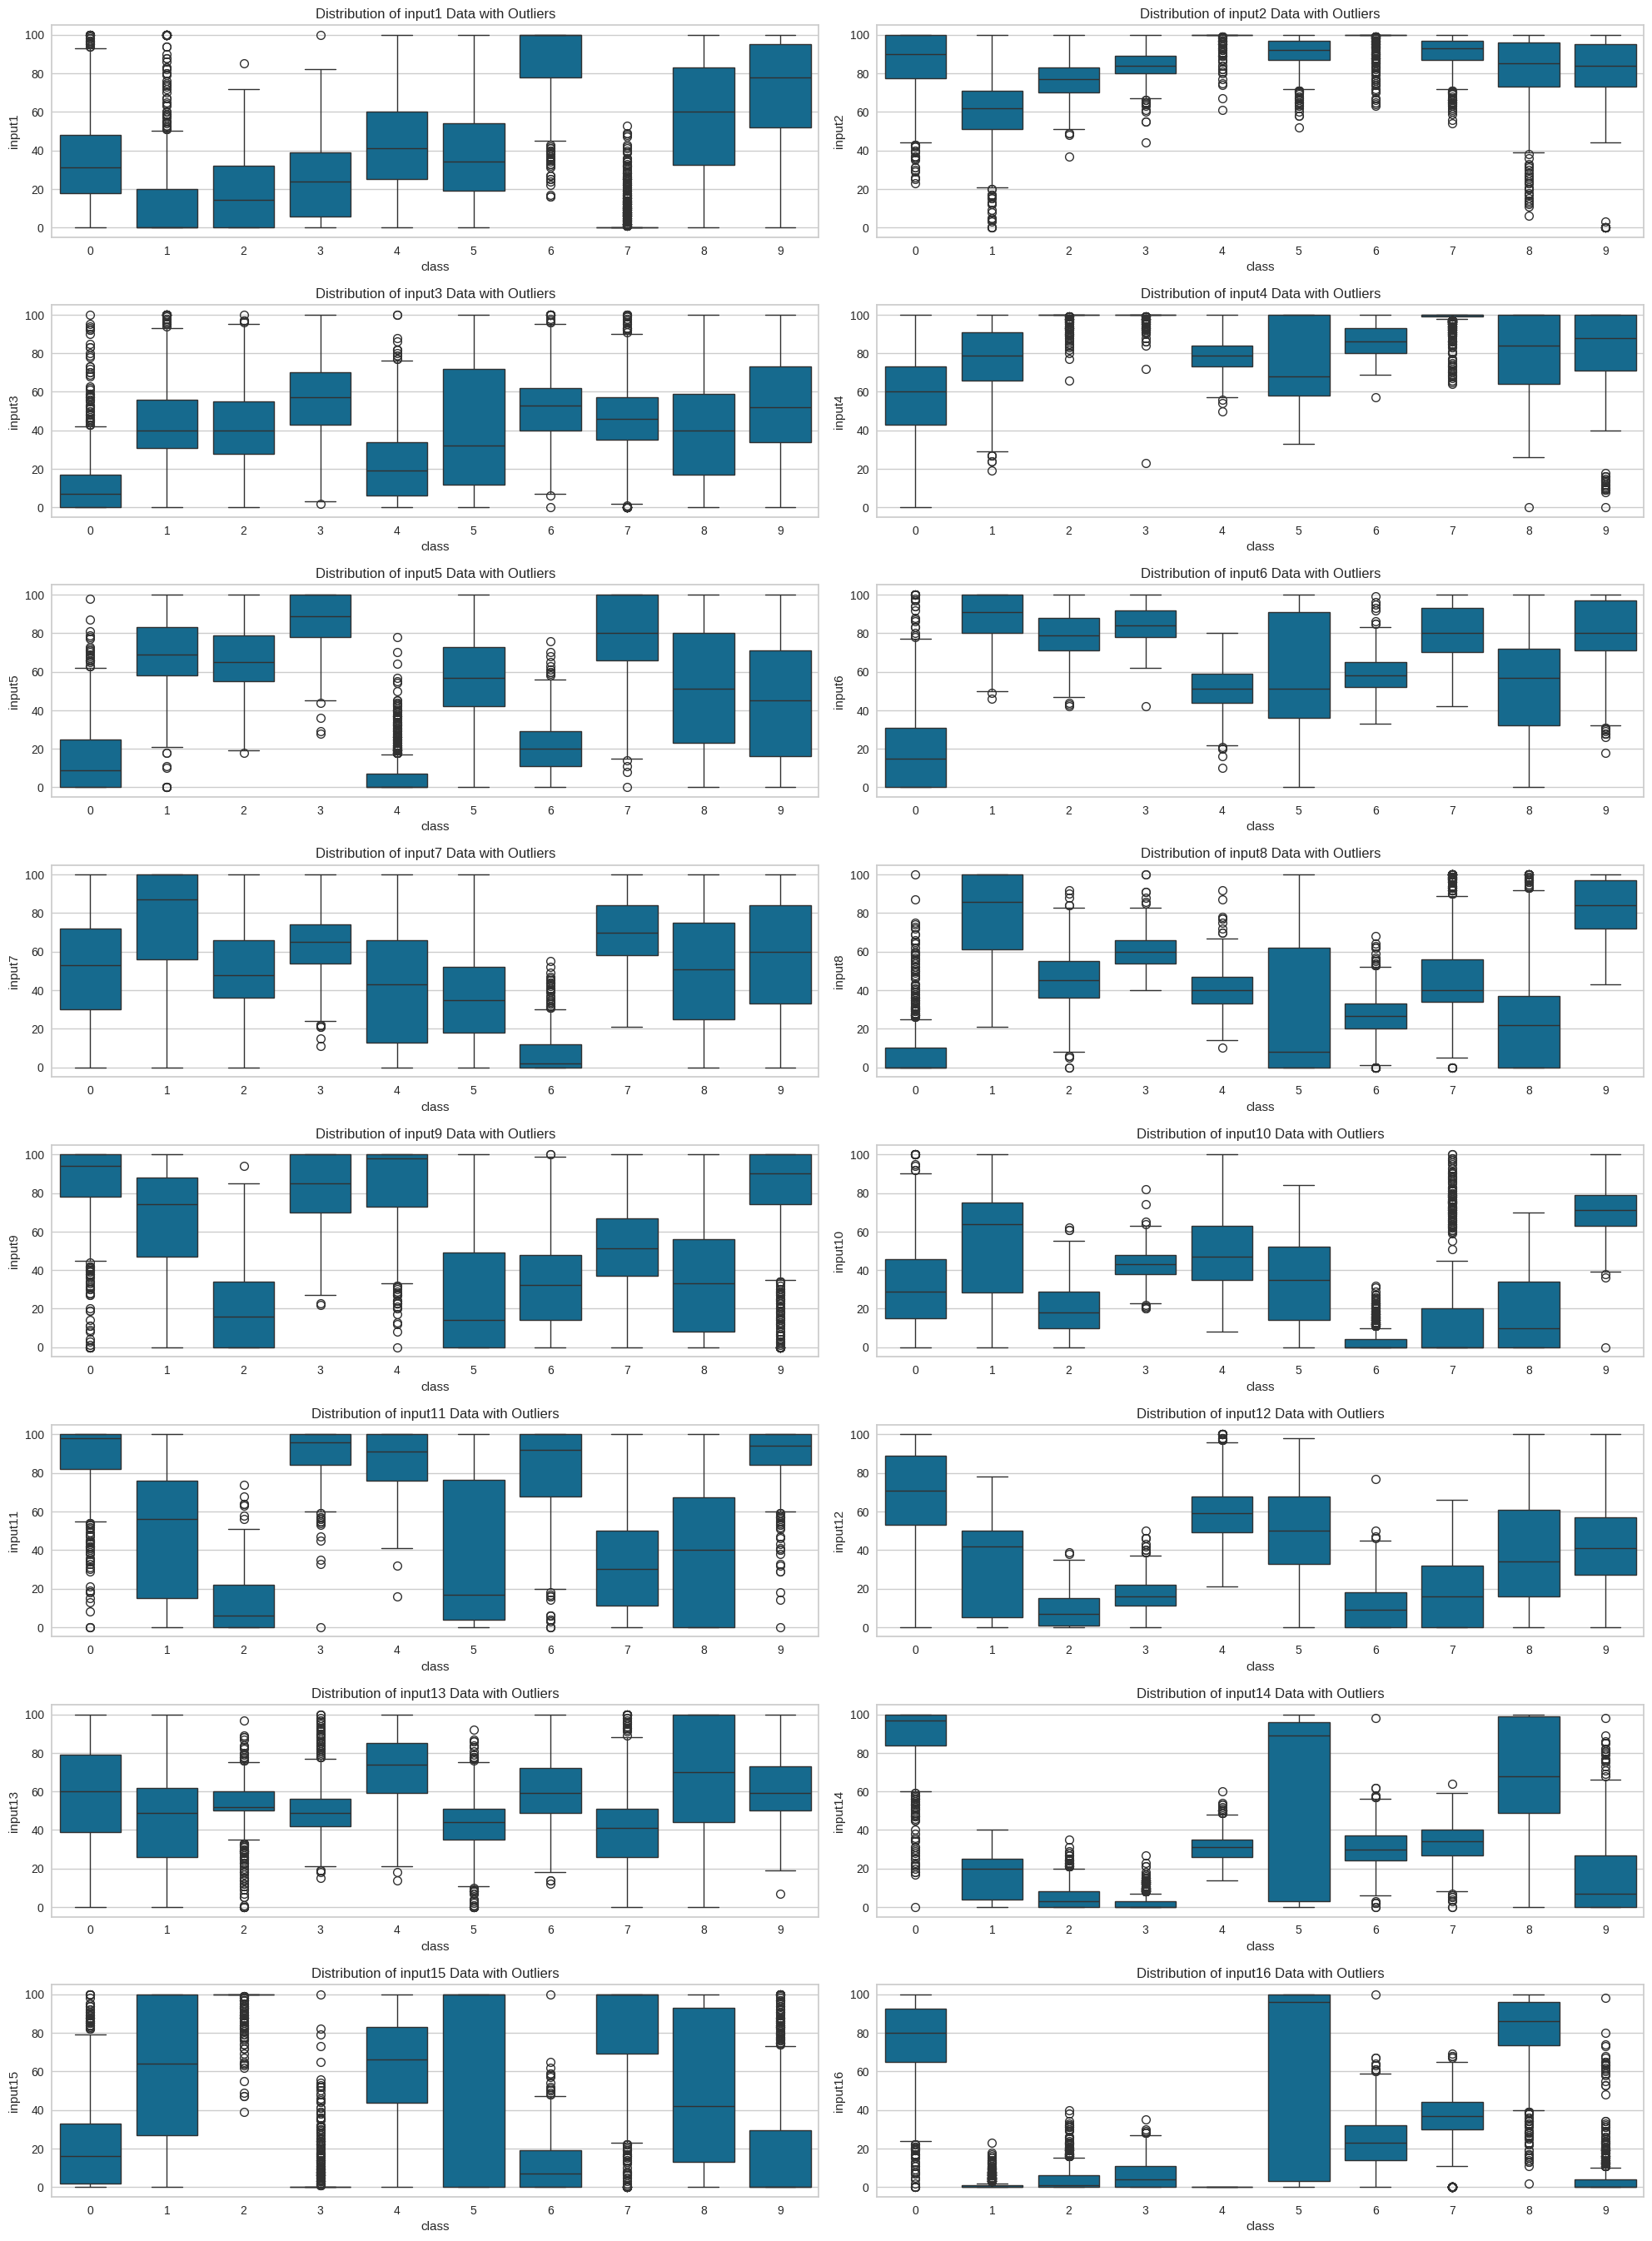

In [ ]:
plot_feature_outliers(df, "class")

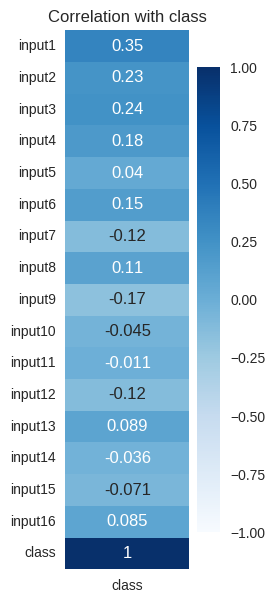

In [ ]:
def plot_target_correlation_heatmap(df, target_variable):

    df_numeric = df.select_dtypes(include=[np.number])
    df_corr_target = df_numeric.corr()

    # Hedef değişkenle korelasyonları içeren ısı haritası oluşturma
    plt.figure(figsize=(2, 7))
    sns.heatmap(df_corr_target[[target_variable]], annot=True, vmin=-1, vmax=1, cmap="Blues")
    plt.title(f'Correlation with {target_variable}')
    plt.show()
plot_target_correlation_heatmap(df, 'class')

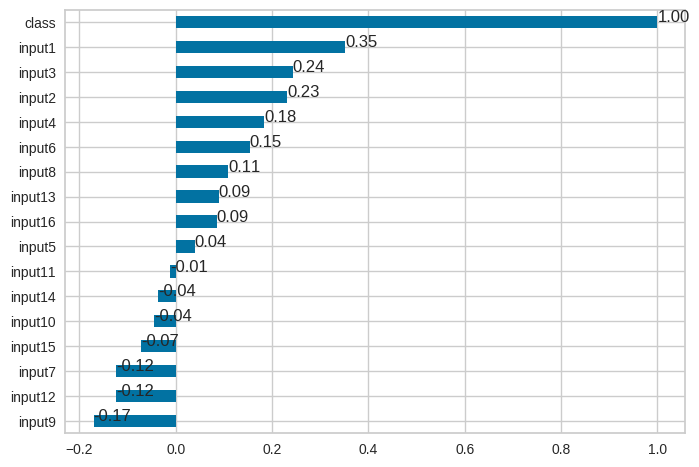

In [ ]:
corr_values = df.corr()["class"].sort_values()
ax = corr_values.plot.barh()
for index, value in enumerate(corr_values):
    plt.text(value, index, "{:.2f}".format(value))

plt.show()

In [ ]:
X = df.drop("class", axis=1)
y = df['class']

##Scaling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Vanillin Model Comparison

In [ ]:
def eval_metric(model, X_train, y_train, X_test, y_test,i):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    print(f"{i} Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print(f"{i} Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

#SVC

In [ ]:
SVM_model = SVC(random_state=101)
SVM_model.fit(X_train_scaled, y_train)

SVC(random_state=101)

In [ ]:
y_pred_test = SVM_model.predict(X_test_scaled)
y_pred_train = SVM_model.predict(X_train_scaled)

SVM_accuracy_test = accuracy_score(y_test, y_pred_test)
SVM_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='macro')
svm_f1_train = f1_score(y_train, y_pred_train, average='macro')

eval_metric(SVM_model, X_train_scaled, y_train, X_test_scaled, y_test, "svm")

svm Test_Set
[[240   0   0   0   0   0   0   0   1   0]
 [  0 222   1   0   1   0   0   1   0   0]
 [  0   0 235   0   0   0   0   0   0   0]
 [  0   0   1 223   0   0   0   0   0   0]
 [  0   0   0   0 215   0   0   0   0   0]
 [  0   0   0   1   0 210   0   0   1   1]
 [  0   0   0   0   0   0 199   0   0   0]
 [  0   1   0   0   0   0   0 208   0   0]
 [  0   0   0   0   0   0   0   1 211   0]
 [  0   0   0   0   0   0   0   2   0 224]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      0.99      0.99       225
           2       0.99      1.00      1.00       235
           3       1.00      1.00      1.00       224
           4       1.00      1.00      1.00       215
           5       1.00      0.99      0.99       213
           6       1.00      1.00      1.00       199
           7       0.98      1.00      0.99       209
           8       0.99      1.00      0.99       212
           9   

In [ ]:
model = SVC()

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy            0.993972
train_accuracy           0.995287
test_precision_macro     0.994038
train_precision_macro    0.995293
test_recall_macro        0.994021
train_recall_macro       0.995302
test_f1_macro            0.993995
train_f1_macro           0.995293
dtype: float64

#DT

In [ ]:
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred_test = DT_model.predict(X_test)
y_pred_train = DT_model.predict(X_train)

DT_accuracy_test = accuracy_score(y_test, y_pred_test)
DT_accuracy_train = accuracy_score(y_train, y_pred_train)

DT_f1_test = f1_score(y_test, y_pred_test, average='macro')
DT_f1_train = f1_score(y_train, y_pred_train, average='macro')

eval_metric(DT_model, X_train, y_train, X_test, y_test, "DT")

DT Test_Set
[[236   0   0   0   0   0   0   0   5   0]
 [  0 210  10   1   1   1   0   1   0   1]
 [  0   8 224   0   0   0   0   3   0   0]
 [  0   2   1 217   0   1   0   2   0   1]
 [  0   0   0   1 209   1   3   1   0   0]
 [  0   0   0   2   0 208   0   0   1   2]
 [  1   0   0   0   1   1 194   0   2   0]
 [  0   3   2   0   0   0   0 201   2   1]
 [  1   1   1   1   0   1   1   0 206   0]
 [  0   3   0   2   3   1   0   5   0 212]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       241
           1       0.93      0.93      0.93       225
           2       0.94      0.95      0.95       235
           3       0.97      0.97      0.97       224
           4       0.98      0.97      0.97       215
           5       0.97      0.98      0.97       213
           6       0.98      0.97      0.98       199
           7       0.94      0.96      0.95       209
           8       0.95      0.97      0.96       212
           9    

In [ ]:
model = DecisionTreeClassifier()

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy            0.960082
train_accuracy           1.000000
test_precision_macro     0.960828
train_precision_macro    1.000000
test_recall_macro        0.959925
train_recall_macro       1.000000
test_f1_macro            0.960059
train_f1_macro           1.000000
dtype: float64

#RF

In [ ]:
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_test = RF_model.predict(X_test)
y_pred_train = RF_model.predict(X_train)

RF_accuracy_test = accuracy_score(y_test, y_pred_test)
RF_accuracy_train = accuracy_score(y_train, y_pred_train)

RF_f1_test = f1_score(y_test, y_pred_test, average='macro')
RF_f1_train = f1_score(y_train, y_pred_train, average='macro')

eval_metric(RF_model, X_train, y_train, X_test, y_test, "RF")

RF Test_Set
[[240   0   0   0   0   0   0   0   1   0]
 [  0 221   3   0   1   0   0   0   0   0]
 [  0   1 233   0   0   0   0   1   0   0]
 [  0   0   0 223   0   0   0   1   0   0]
 [  0   0   0   0 215   0   0   0   0   0]
 [  0   0   0   1   0 210   0   0   1   1]
 [  0   0   0   0   0   0 199   0   0   0]
 [  0   0   0   0   0   0   0 209   0   0]
 [  0   0   0   0   0   0   0   2 210   0]
 [  0   1   0   0   0   0   0   1   0 224]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       0.99      0.98      0.99       225
           2       0.99      0.99      0.99       235
           3       1.00      1.00      1.00       224
           4       1.00      1.00      1.00       215
           5       1.00      0.99      0.99       213
           6       1.00      1.00      1.00       199
           7       0.98      1.00      0.99       209
           8       0.99      0.99      0.99       212
           9    

In [ ]:
model = RandomForestClassifier()

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"],
                        cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy            0.990561
train_accuracy           1.000000
test_precision_macro     0.990837
train_precision_macro    1.000000
test_recall_macro        0.990641
train_recall_macro       1.000000
test_f1_macro            0.990660
train_f1_macro           1.000000
dtype: float64

#Vanillin Model Comparison

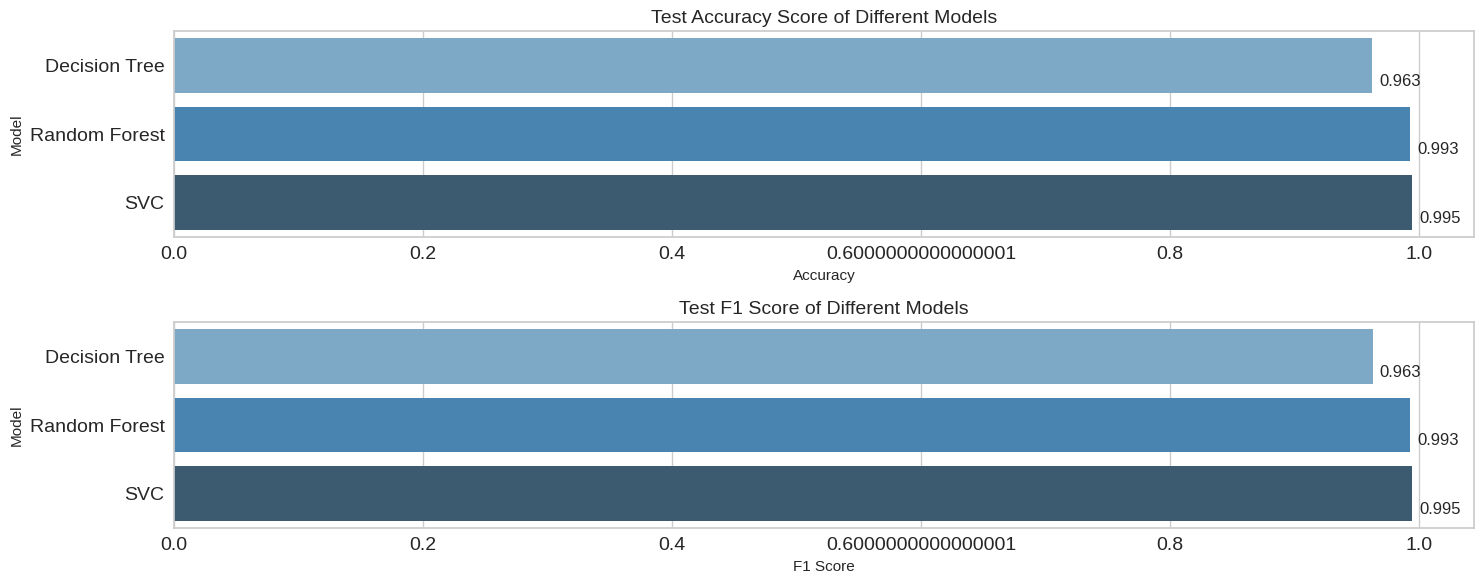

In [ ]:
# Verilerin hazırlanması
compare_accuracy = pd.DataFrame({
    "Model": ["SVC", "Decision Tree", "Random Forest"],
    "Accuracy": [SVM_accuracy_test, DT_accuracy_test, RF_accuracy_test]
})

compare_accuracy = compare_accuracy.sort_values(by="Accuracy", ascending=True)

compare_f1 = pd.DataFrame({
    "Model": ["SVC", "Decision Tree", "Random Forest"],
    "F1 Score": [svm_f1_test, DT_f1_test, RF_f1_test]
})

compare_f1 = compare_f1.sort_values(by="F1 Score", ascending=True)

# Grafiklerin oluşturulması
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# Test Accuracy Score grafiği
ax1 = sns.barplot(x="Accuracy", y="Model", data=compare_accuracy, palette="Blues_d", ax=axes[0])
for p in ax1.patches:
    ax1.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                 xytext=(5, 10), textcoords='offset points')
ax1.set_title("Test Accuracy Score of Different Models", size=14)
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels(ax1.get_yticklabels(), size=14)
ax1.set_xticklabels(ax1.get_xticks(), size=14)

# Test F1 Score grafiği
ax2 = sns.barplot(x="F1 Score", y="Model", data=compare_f1, palette="Blues_d", ax=axes[1])
for p in ax2.patches:
    ax2.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                 xytext=(5, 10), textcoords='offset points')
ax2.set_title("Test F1 Score of Different Models", size=14)
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels(ax2.get_yticklabels(), size=14)
ax2.set_xticklabels(ax2.get_xticks(), size=14)

plt.tight_layout()
plt.show()


# **Support Vector Machine(SVM)Classifier**

In [ ]:
param_grid = {'C': [0.1, 1, 1.5],
              'gamma': ["scale", "auto", 0.2, 0.5]}

In [ ]:
SVM_model = SVC(kernel="rbf",probability=True)

SVM_model_grid = GridSearchCV(SVM_model,
                              param_grid,
                              verbose=2,
                              scoring="accuracy",
                              n_jobs=-1).fit(X_train_scaled, y_train)
# I skipped cv because the scores were close, I already have cv in gridsearch  cv=5

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
SVM_model_grid.best_params_

{'C': 1.5, 'gamma': 0.2}

In [ ]:
y_pred_test = SVM_model_grid.predict(X_test_scaled)
y_pred_train = SVM_model_grid.predict(X_train_scaled)

SVM_accuracy_test = accuracy_score(y_test, y_pred_test)
SVM_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='macro')
svm_f1_train = f1_score(y_train, y_pred_train, average='macro')

eval_metric(SVM_model_grid, X_train_scaled, y_train, X_test_scaled, y_test, "svm grid")

svm grid Test_Set
[[240   0   0   0   0   0   0   0   1   0]
 [  0 223   1   0   1   0   0   0   0   0]
 [  0   0 235   0   0   0   0   0   0   0]
 [  0   0   1 223   0   0   0   0   0   0]
 [  0   0   0   0 215   0   0   0   0   0]
 [  0   0   0   1   0 209   0   0   3   0]
 [  0   0   0   0   0   0 199   0   0   0]
 [  0   0   0   0   0   0   0 209   0   0]
 [  0   0   0   0   0   0   0   0 212   0]
 [  0   0   0   0   1   0   0   2   0 223]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       241
           1       1.00      0.99      1.00       225
           2       0.99      1.00      1.00       235
           3       1.00      1.00      1.00       224
           4       0.99      1.00      1.00       215
           5       1.00      0.98      0.99       213
           6       1.00      1.00      1.00       199
           7       0.99      1.00      1.00       209
           8       0.98      1.00      0.99       212
          

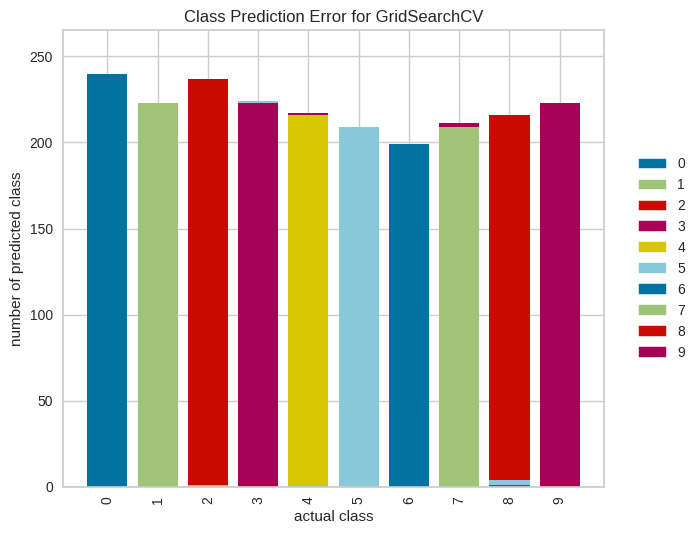

In [ ]:
visualizer = ClassPredictionError(SVM_model_grid)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test)

# Draw visualization
visualizer.show();

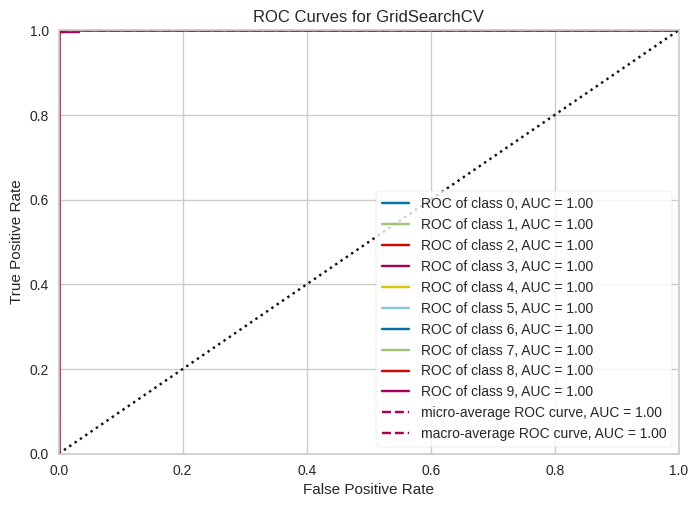

In [ ]:
visualizer = ROCAUC(SVM_model_grid, classes=[str(i) for i in range(10)])

visualizer.fit(X_train_scaled, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)        # Evaluate the model on the test data
visualizer.show();

In [ ]:
y_pred = SVM_model_grid.predict(X_test_scaled)
residuals = y_test-y_pred

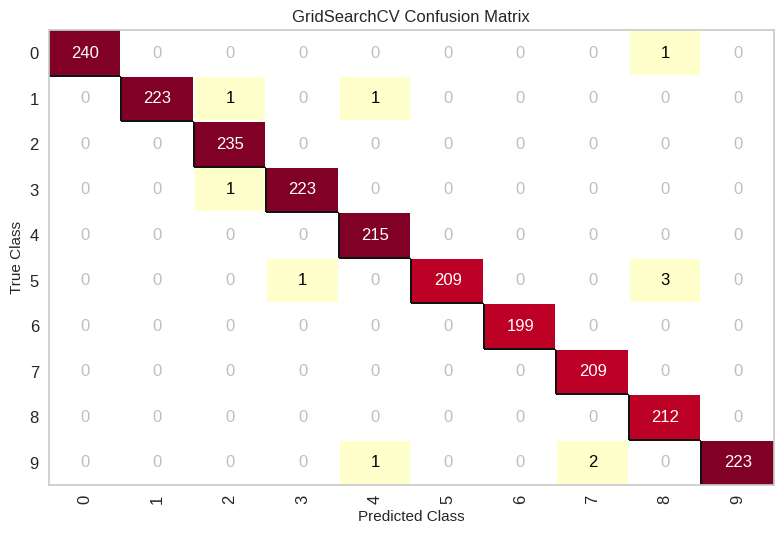

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

visualizer = ConfusionMatrix(SVM_model_grid)

visualizer.fit(X_train_scaled, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show();

#Desicion Tree Classification Model

In [ ]:
param_grid = {
             'criterion': ["entropy","gini"],
             'max_depth':[10, 11, 12],
             'max_features':[0.1, 0.8],
             'max_leaf_nodes': [200,210],
             'splitter': ['best', 'random'],
             }

DT_model = DecisionTreeClassifier()
DT_grid_model = GridSearchCV(DT_model,
                             param_grid,
                             verbose=2,
                             scoring="accuracy",
                             n_jobs=-1)

DT_grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 11, 12], 'max_features': [0.1, 0.8],
                         'max_leaf_nodes': [200, 210],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=2)

In [ ]:
DT_grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 0.8,
 'max_leaf_nodes': 200,
 'splitter': 'best'}

In [ ]:
y_pred_test = DT_grid_model.predict(X_test)
y_pred_train =DT_grid_model.predict(X_train)

DT_accuracy_test = accuracy_score(y_test, y_pred_test)
DT_accuracy_train = accuracy_score(y_train, y_pred_train)

DT_f1_test = f1_score(y_test, y_pred_test, average='macro')
DT_f1_train = f1_score(y_train, y_pred_train, average='macro')

eval_metric(DT_grid_model, X_train, y_train, X_test, y_test, "DT")

DT Test_Set
[[234   1   0   0   0   0   0   1   4   1]
 [  0 211  10   0   2   0   1   1   0   0]
 [  0   6 225   0   0   0   1   3   0   0]
 [  0   1   0 219   0   1   0   0   1   2]
 [  0   0   0   0 209   2   1   0   0   3]
 [  0   0   1   3   1 201   1   0   0   6]
 [  0   0   0   0   0   1 197   0   1   0]
 [  0   6   0   2   0   0   1 199   1   0]
 [  1   0   0   0   0   1   2   0 208   0]
 [  3   3   0   1   4   1   0   1   0 213]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       241
           1       0.93      0.94      0.93       225
           2       0.95      0.96      0.96       235
           3       0.97      0.98      0.98       224
           4       0.97      0.97      0.97       215
           5       0.97      0.94      0.96       213
           6       0.97      0.99      0.98       199
           7       0.97      0.95      0.96       209
           8       0.97      0.98      0.97       212
           9    

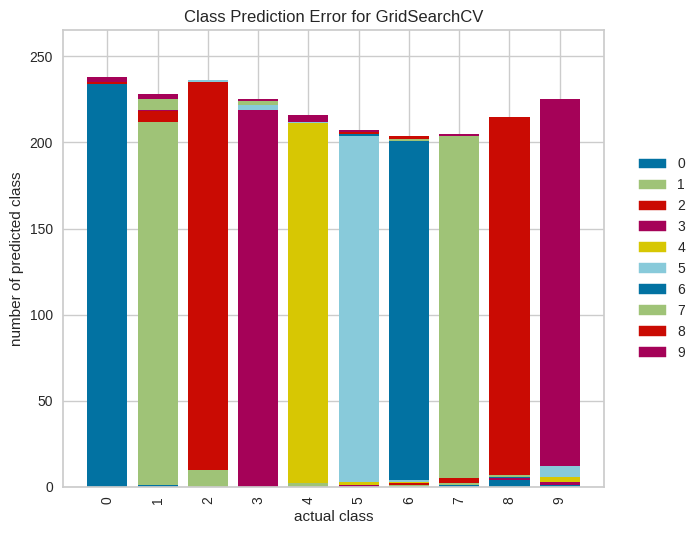

<Axes: title={'center': 'Class Prediction Error for GridSearchCV'}, xlabel='actual class', ylabel='number of predicted class'>

In [ ]:
visualizer = ClassPredictionError(DT_grid_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

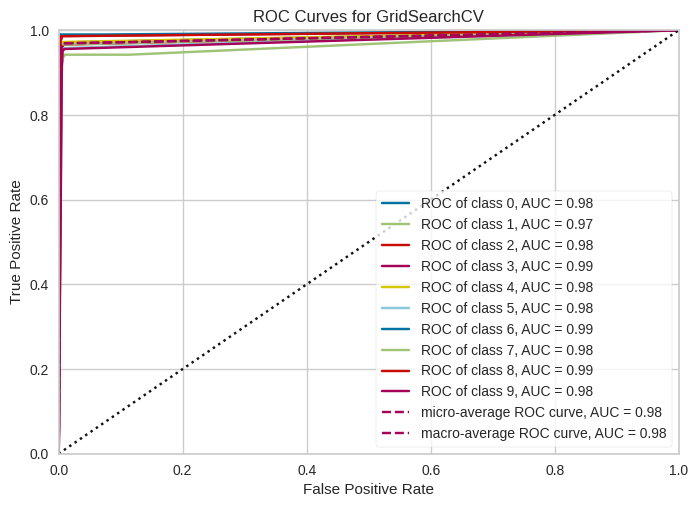

In [ ]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(DT_grid_model, classes=[str(i) for i in range(10)])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and render the figure

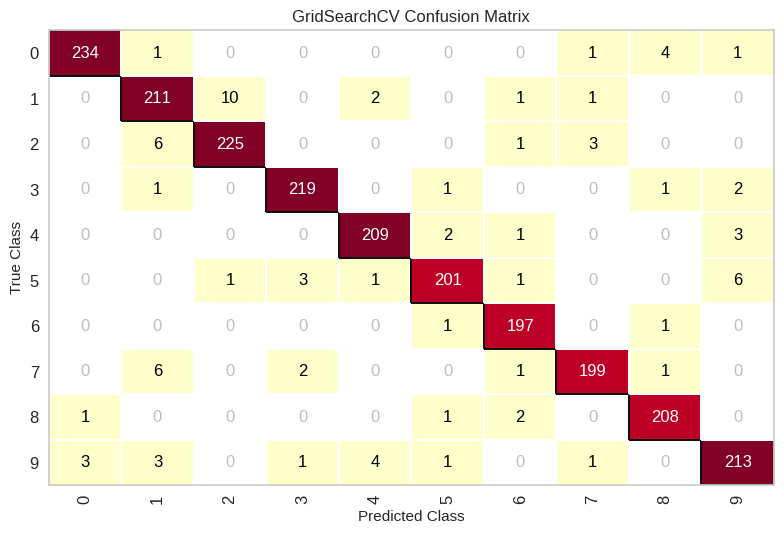

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

y_pred = DT_grid_model.predict(X_test)
residuals = y_test-y_pred


visualizer = ConfusionMatrix(DT_grid_model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

#Random Forest Classsifier

In [ ]:
param_grid = {
             'criterion': ["entropy","gini"],
             'max_depth':[10, 15],
             'max_features':[ 0.8,1 ],
             'max_leaf_nodes': [180,200],
             'n_estimators':[50,100],
             }

rf_model = RandomForestClassifier()
rf_grid_model = GridSearchCV(rf_model,
                             param_grid,
                             verbose=2,
                             scoring="accuracy",
                             n_jobs=-1)

rf_grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 15], 'max_features': [0.8, 1],
                         'max_leaf_nodes': [180, 200],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [ ]:
rf_grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 0.8,
 'max_leaf_nodes': 200,
 'n_estimators': 100}

In [ ]:
y_pred_test = rf_grid_model.predict(X_test)
y_pred_train =rf_grid_model.predict(X_train)

RF_accuracy_test = accuracy_score(y_test, y_pred_test)
RF_accuracy_train = accuracy_score(y_train, y_pred_train)

RF_f1_test = f1_score(y_test, y_pred_test, average='macro')
RF_f1_train = f1_score(y_train, y_pred_train, average='macro')

eval_metric(rf_grid_model, X_train, y_train, X_test, y_test, "RF")

RF Test_Set
[[239   0   0   0   0   0   0   0   2   0]
 [  0 219   5   0   1   0   0   0   0   0]
 [  0   1 232   0   0   0   0   2   0   0]
 [  0   1   1 221   0   1   0   0   0   0]
 [  0   0   0   0 215   0   0   0   0   0]
 [  0   0   0   0   0 209   1   0   1   2]
 [  0   0   0   0   0   0 199   0   0   0]
 [  0   0   0   0   0   0   0 208   1   0]
 [  1   0   0   0   0   0   0   1 210   0]
 [  0   1   0   0   0   0   0   1   0 224]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       241
           1       0.99      0.97      0.98       225
           2       0.97      0.99      0.98       235
           3       1.00      0.99      0.99       224
           4       1.00      1.00      1.00       215
           5       1.00      0.98      0.99       213
           6       0.99      1.00      1.00       199
           7       0.98      1.00      0.99       209
           8       0.98      0.99      0.99       212
           9    

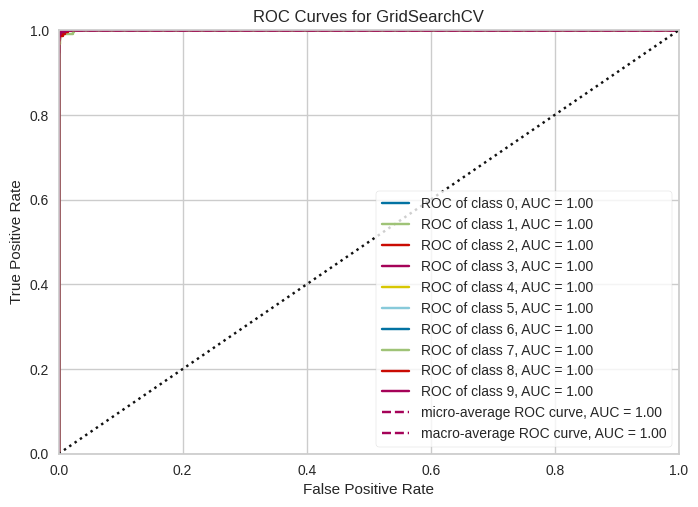

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf_grid_model, classes=[str(i) for i in range(10)])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

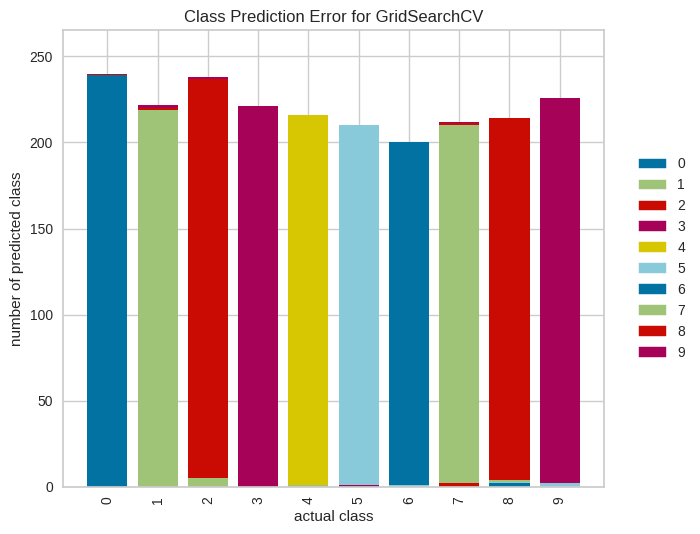

In [ ]:
visualizer = ClassPredictionError(rf_grid_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show();

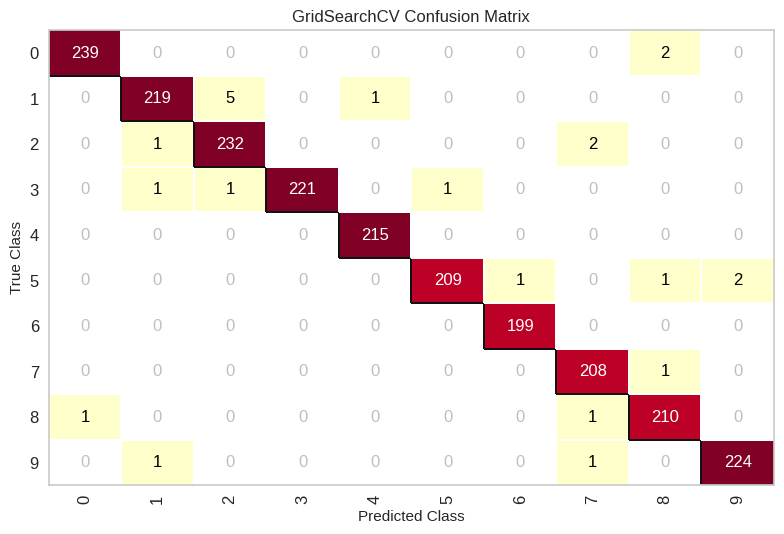

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

y_pred = rf_grid_model.predict(X_test)
residuals = y_test-y_pred


visualizer = ConfusionMatrix(rf_grid_model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

#Compare Model Perfomance

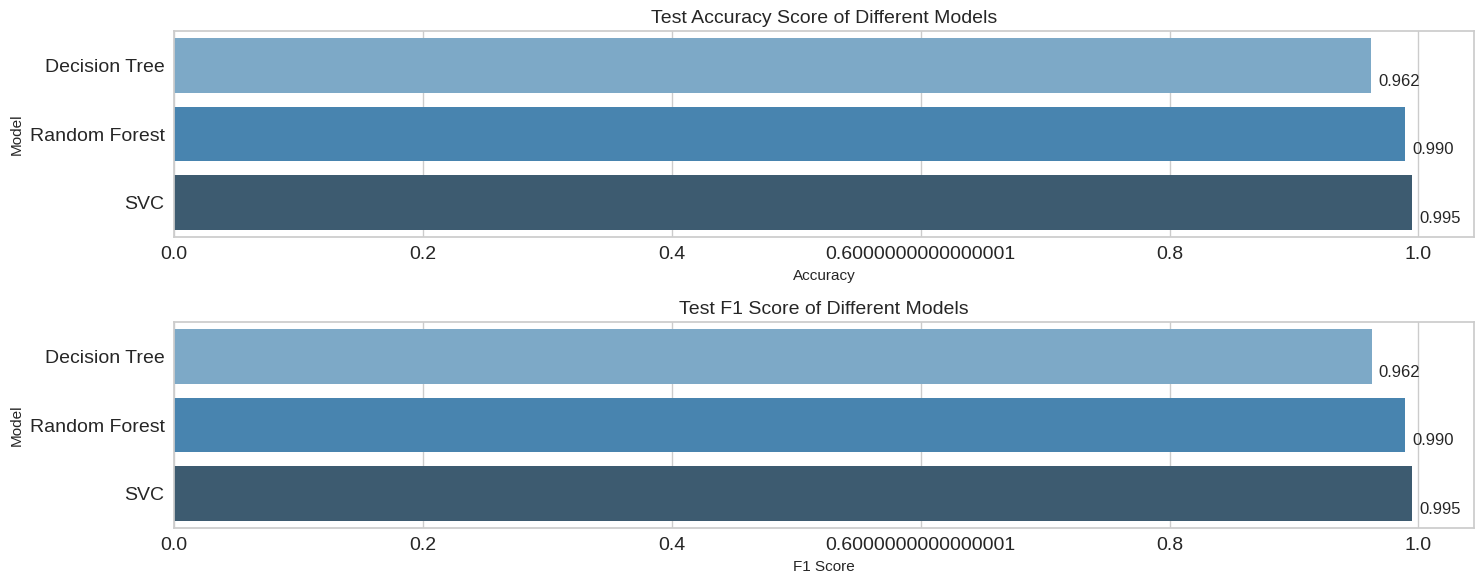

In [ ]:
# Verilerin hazırlanması
compare_accuracy = pd.DataFrame({
    "Model": ["SVC", "Decision Tree", "Random Forest"],
    "Accuracy": [SVM_accuracy_test, DT_accuracy_test, RF_accuracy_test]
})

compare_accuracy = compare_accuracy.sort_values(by="Accuracy", ascending=True)

compare_f1 = pd.DataFrame({
    "Model": ["SVC", "Decision Tree", "Random Forest"],
    "F1 Score": [svm_f1_test, DT_f1_test, RF_f1_test]
})

compare_f1 = compare_f1.sort_values(by="F1 Score", ascending=True)

# Grafiklerin oluşturulması
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# Test Accuracy Score grafiği
ax1 = sns.barplot(x="Accuracy", y="Model", data=compare_accuracy, palette="Blues_d", ax=axes[0])
for p in ax1.patches:
    ax1.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                 xytext=(5, 10), textcoords='offset points')
ax1.set_title("Test Accuracy Score of Different Models", size=14)
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels(ax1.get_yticklabels(), size=14)
ax1.set_xticklabels(ax1.get_xticks(), size=14)

# Test F1 Score grafiği
ax2 = sns.barplot(x="F1 Score", y="Model", data=compare_f1, palette="Blues_d", ax=axes[1])
for p in ax2.patches:
    ax2.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                 xytext=(5, 10), textcoords='offset points')
ax2.set_title("Test F1 Score of Different Models", size=14)
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels(ax2.get_yticklabels(), size=14)
ax2.set_xticklabels(ax2.get_xticks(), size=14)

plt.tight_layout()
plt.show()


#Choose the best Model

In [ ]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [ ]:
param_grid = {'C': [1.5],
              'gamma': [0.2]}

SVM_model = SVC(kernel="rbf",probability=True)

final_model = GridSearchCV(SVM_model,
                              param_grid,
                              verbose=2,
                              scoring="accuracy",
                              n_jobs=-1).fit(X_scaled, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
import pickle
pickle.dump(final_model, open("final_pipe_model", "wb"))

In [ ]:
new_model = pickle.load(open("final_pipe_model", "rb"))
new_model

GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1.5], 'gamma': [0.2]}, scoring='accuracy',
             verbose=2)